## A2: Predicting Car Price

### Task 1: Implementation

From A1, I modified the features used and retrained the model, instead of using all the features as before, I changed them to 5 features: km_driven, owner, mileage, engine and max_power.

#### 1. Import libraries and check version libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings
import matplotlib
from itertools import combinations_with_replacement
warnings.filterwarnings('ignore')

#### 2. Load data

In [2]:
df = pd.read_csv('Cars.csv')

In [3]:
# print the first rows of data
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [4]:
# Check the shape of data
df.shape

(8128, 13)

In [5]:
# Show basic statistics (count, mean, std, min, max, percentile)
df.describe()

,year,selling_price,km_driven,seats
count,8128.000000,8.128000e+03,8.128000e+03,7907.000000
mean,2013.804011,6.382718e+05,6.981951e+04,5.416719
std,4.044249,8.062534e+05,5.655055e+04,0.959588
min,1983.000000,2.999900e+04,1.000000e+00,2.000000
25%,2011.000000,2.549990e+05,3.500000e+04,5.000000
50%,2015.000000,4.500000e+05,6.000000e+04,5.000000
75%,2017.000000,6.750000e+05,9.800000e+04,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,14.000000


In [6]:
# Check Dtypes of input data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


In [7]:
# Check the column names
df.columns

Index(['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'mileage', 'engine', 'max_power', 'torque',
       'seats'],
      dtype='object')

#### 3. Data cleaning and preprocessing

- For the feature owner, map First owner to 1, ..., Test Drive Car to 5

In [8]:
# Define the custom mapping
owner_mapping = {
    'First Owner': 1,
    'Second Owner': 2,
    'Third Owner': 3,
    'Fourth & Above Owner': 4,
    'Test Drive Car': 5
}

df["owner"] = df["owner"].map(owner_mapping)    # Apply the mapping to the 'owner' column
print(df["owner"].unique()) # Display unique mapped

[1 2 3 4 5]


In [9]:
# Check data after mapping
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,1,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,2,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,3,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,1,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,1,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


- For the feature fuel, remove all rows with CNG and LPG because CNG and LPG use a different mileage system i.e., km/kg which is different from kmpl for Diesel and Petrol

<Axes: xlabel='fuel', ylabel='count'>

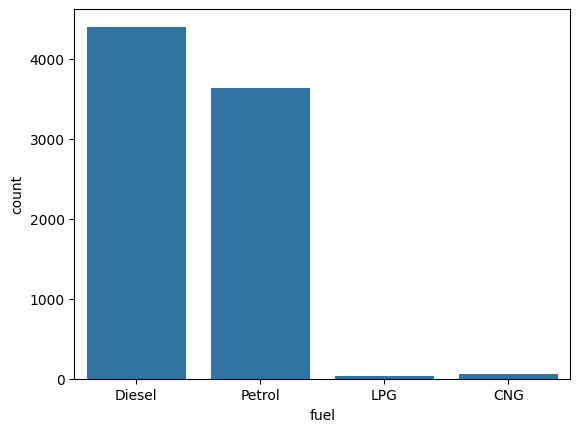

In [10]:
# Check number of row are CNG and LPG
sns.countplot(data = df, x = 'fuel')

In [11]:
# Check what index in the fuel column contains a value for CNG or LPG
index_to_drop = df[df["fuel"].isin(["CNG", "LPG"])].index

# Count number of rows
num_to_drop = len(index_to_drop)

# Show number of rows must remove and show the index contains a value for CNG or LPG
print(f"Number of rows to drop: {num_to_drop}")
print(f"Index to drop: {index_to_drop.tolist()}")

Number of rows to drop: 95
Index to drop: [6, 35, 90, 203, 402, 866, 870, 1225, 1239, 1350, 1511, 1658, 1907, 2047, 2108, 2166, 2253, 2312, 2466, 2481, 2484, 2513, 2518, 2525, 2527, 2573, 2579, 2588, 2613, 2618, 2730, 2740, 2758, 2767, 3010, 3042, 3050, 3200, 3216, 3306, 3466, 3492, 3751, 3796, 3823, 3826, 3853, 3908, 3912, 3956, 4004, 4045, 4542, 4545, 4933, 5034, 5057, 5133, 5185, 5198, 5199, 5206, 5277, 5322, 5436, 5437, 5457, 5532, 5557, 5578, 5749, 5768, 5784, 5789, 5792, 5793, 5815, 6007, 6253, 6338, 6488, 6536, 6651, 6856, 7040, 7101, 7112, 7166, 7245, 7300, 7308, 7543, 7642, 7733, 7913]


In [12]:
rows_before = len(df)   # Before remove
df = df.drop(index_to_drop) # Remove row are CNG and LPG
rows_after = len(df)    # After remove

print(f"Rows before drop: {rows_before}")
print(f"Rows after drop: {rows_after}")

Rows before drop: 8128
Rows after drop: 8033


- For the feature mileage, remove “kmpl” and convert the column to numerical type (e.g., float). Hint: use df.mileage.str.split

In [13]:
df["mileage"] = df["mileage"].str.split(" ").str[0].astype(float)   # Split by space and keep only the first part

In [14]:
# Check 'mileage' column to verify the transformation
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,1,23.40,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,2,21.14,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,3,17.70,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,1,23.00,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,1,16.10,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [15]:
# Check the data type
print(df["mileage"].dtypes)

float64


- For the feature engine, remove “CC” and convert the column to numerical type (e.g., float)

In [16]:
df["engine"] = df["engine"].str.split(" ").str[0].astype(float)   # Split by space and keep only the first part

In [17]:
# Check 'engine' column to verify the transformation
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,1,23.40,1248.0,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,2,21.14,1498.0,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,3,17.70,1497.0,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,1,23.00,1396.0,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,1,16.10,1298.0,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [18]:
# Check the data type
print(df["engine"].dtypes)

float64


- For the feature max_power, remove “bhp” and convert the column to numerical type (e.g., float)

In [19]:
df["max_power"] = df["max_power"].str.split(" ").str[0].astype(float)   # Split by space and keep only the first part

In [20]:
# Check 'max_power' column to verify the transformation
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,1,23.40,1248.0,74.00,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,2,21.14,1498.0,103.52,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,3,17.70,1497.0,78.00,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,1,23.00,1396.0,90.00,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,1,16.10,1298.0,88.20,"11.5@ 4,500(kgm@ rpm)",5.0


In [21]:
# Check the data type
print(df["max_power"].dtypes)

float64


- Drop unused features

In [22]:
df = df.drop('name', axis='columns')
df = df.drop('year', axis='columns')
df = df.drop('fuel', axis='columns')
df = df.drop('seller_type', axis='columns')
df = df.drop('transmission', axis='columns')
df = df.drop('torque', axis='columns')
df = df.drop('seats', axis='columns')

In [23]:
# Check after remove column "torque"
df.head()

,selling_price,km_driven,owner,mileage,engine,max_power
0,450000,145500,1,23.40,1248.0,74.00
1,370000,120000,2,21.14,1498.0,103.52
2,158000,140000,3,17.70,1497.0,78.00
3,225000,127000,1,23.00,1396.0,90.00
4,130000,120000,1,16.10,1298.0,88.20


- You will found out that Test Drive Cars are ridiculously expensive. Since we do not want to involve this, we will simply delete all samples related to it.

dtype('int64')

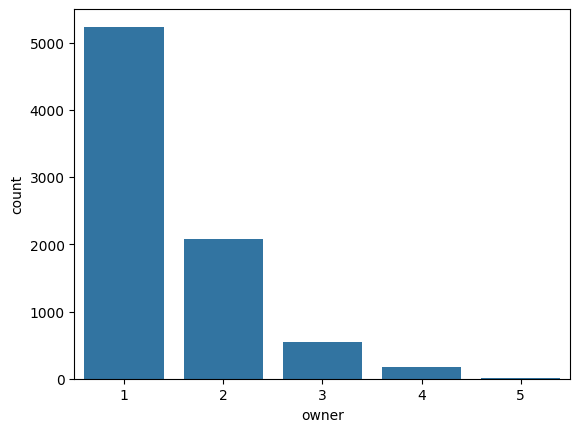

In [24]:
# Check number of row are "Test Drive Cars"
sns.countplot(data = df, x = 'owner')

'''
For mapping
    'First Owner': 1,
    'Second Owner': 2,
    'Third Owner': 3,
    'Fourth & Above Owner': 4,
    'Test Drive Car': 5
'''

df["owner"].dtypes

In [25]:
# Check what index in the owner column contains a value '5'
index_to_drop_owner = df[df["owner"].isin([5])].index

# Count number of rows
num_to_drop_owner = len(index_to_drop_owner)

# Show number of rows must remove and show the index contains a value '5'
print(f"Number of rows to drop: {num_to_drop_owner}")
print(f"Index to drop: {index_to_drop_owner.tolist()}")

Number of rows to drop: 5
Index to drop: [4383, 4950, 4951, 4952, 6220]


In [26]:
rows_before = len(df)   # Before remove
df = df.drop(index_to_drop_owner) # Remove row is '5'
rows_after = len(df)    # After remove

print(f"Rows before drop: {rows_before}")
print(f"Rows after drop: {rows_after}")

Rows before drop: 8033
Rows after drop: 8028


<Axes: xlabel='owner', ylabel='count'>

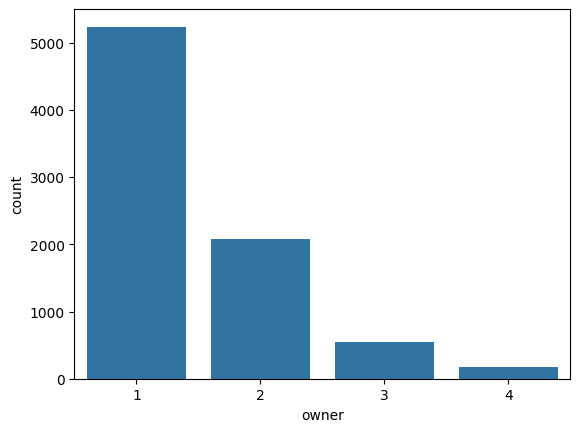

In [27]:
# Check data again
sns.countplot(data = df, x = 'owner')

- Since selling price is a big number, it can cause your prediction to be very unstable. One trick is to first transform the label using log transform, i.e., "y = np.log(df['selling_price'])"

In [28]:
df['selling_price'] = np.log(df['selling_price'])   # log transformation

In [29]:
# Check data
df.head()

,selling_price,km_driven,owner,mileage,engine,max_power
0,13.017003,145500,1,23.40,1248.0,74.00
1,12.821258,120000,2,21.14,1498.0,103.52
2,11.970350,140000,3,17.70,1497.0,78.00
3,12.323856,127000,1,23.00,1396.0,90.00
4,11.775290,120000,1,16.10,1298.0,88.20


- Feature selection

In [30]:
#x is our strong features
X = df[        ['km_driven', 'owner', 'mileage', 'engine', 'max_power']        ]

#y is simply the selling_price col
y = df["selling_price"]

- After I get cleaned data I will split data to train set and test set

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

- Preprocessing train data

In [32]:
#check for null values
X_train[['km_driven', 'owner', 'mileage', 'engine', 'max_power']].isna().sum()

km_driven      0
owner          0
mileage      154
engine       154
max_power    149
dtype: int64

In [33]:
X_test[['km_driven', 'owner', 'mileage', 'engine', 'max_power']].isna().sum()

km_driven     0
owner         0
mileage      60
engine       60
max_power    59
dtype: int64

In [34]:
y_train.isna().sum()

np.int64(0)

In [35]:
y_test.isna().sum()

np.int64(0)

Preprocessing for mileage data

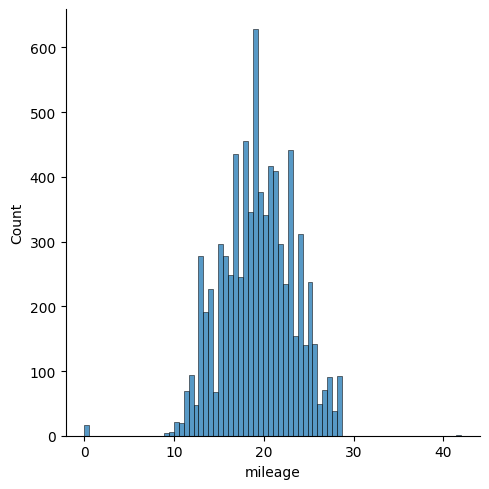

In [36]:
sns.displot(data=df, x='mileage')

In [37]:
X_train['mileage'].fillna(X_train['mileage'].median(), inplace=True)
X_test['mileage'].fillna(X_train['mileage'].median(), inplace=True)

Preprocessing for engine data

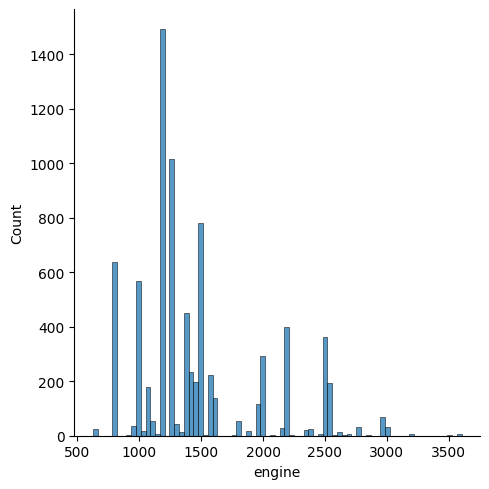

In [38]:
sns.displot(data=df, x='engine')

In [39]:
df.engine.mean(), df.engine.median()

(np.float64(1462.9146403890454), np.float64(1248.0))

In [40]:
X_train['engine'].fillna(X_train['engine'].median(), inplace=True)
X_test['engine'].fillna(X_train['engine'].median(), inplace=True)

Preprocessing for max power data

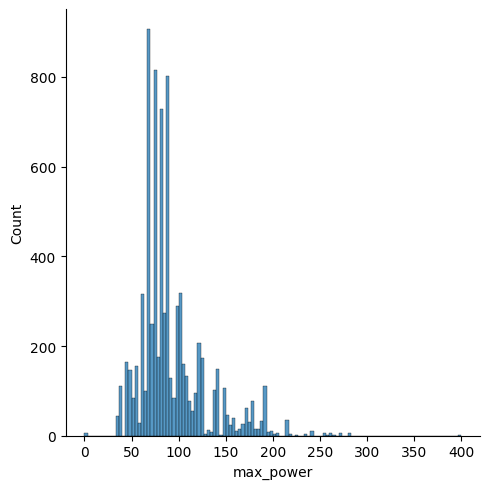

In [41]:
sns.displot(data=df, x='max_power')

In [42]:
X_train['max_power'].fillna(X_train['max_power'].median(), inplace=True)
X_test['max_power'].fillna(X_train['max_power'].median(), inplace=True)

In [43]:
# Check again
X_train[['km_driven', 'owner', 'mileage', 'engine', 'max_power']].isna().sum()

km_driven    0
owner        0
mileage      0
engine       0
max_power    0
dtype: int64

In [44]:
X_test[['km_driven', 'owner', 'mileage', 'engine', 'max_power']].isna().sum()

km_driven    0
owner        0
mileage      0
engine       0
max_power    0
dtype: int64

In [45]:
y_train.isna().sum()

np.int64(0)

In [46]:
y_test.isna().sum()

np.int64(0)

Checking Outliers

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8028 entries, 0 to 8127
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   selling_price  8028 non-null   float64
 1   km_driven      8028 non-null   int64  
 2   owner          8028 non-null   int64  
 3   mileage        7814 non-null   float64
 4   engine         7814 non-null   float64
 5   max_power      7820 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 439.0 KB


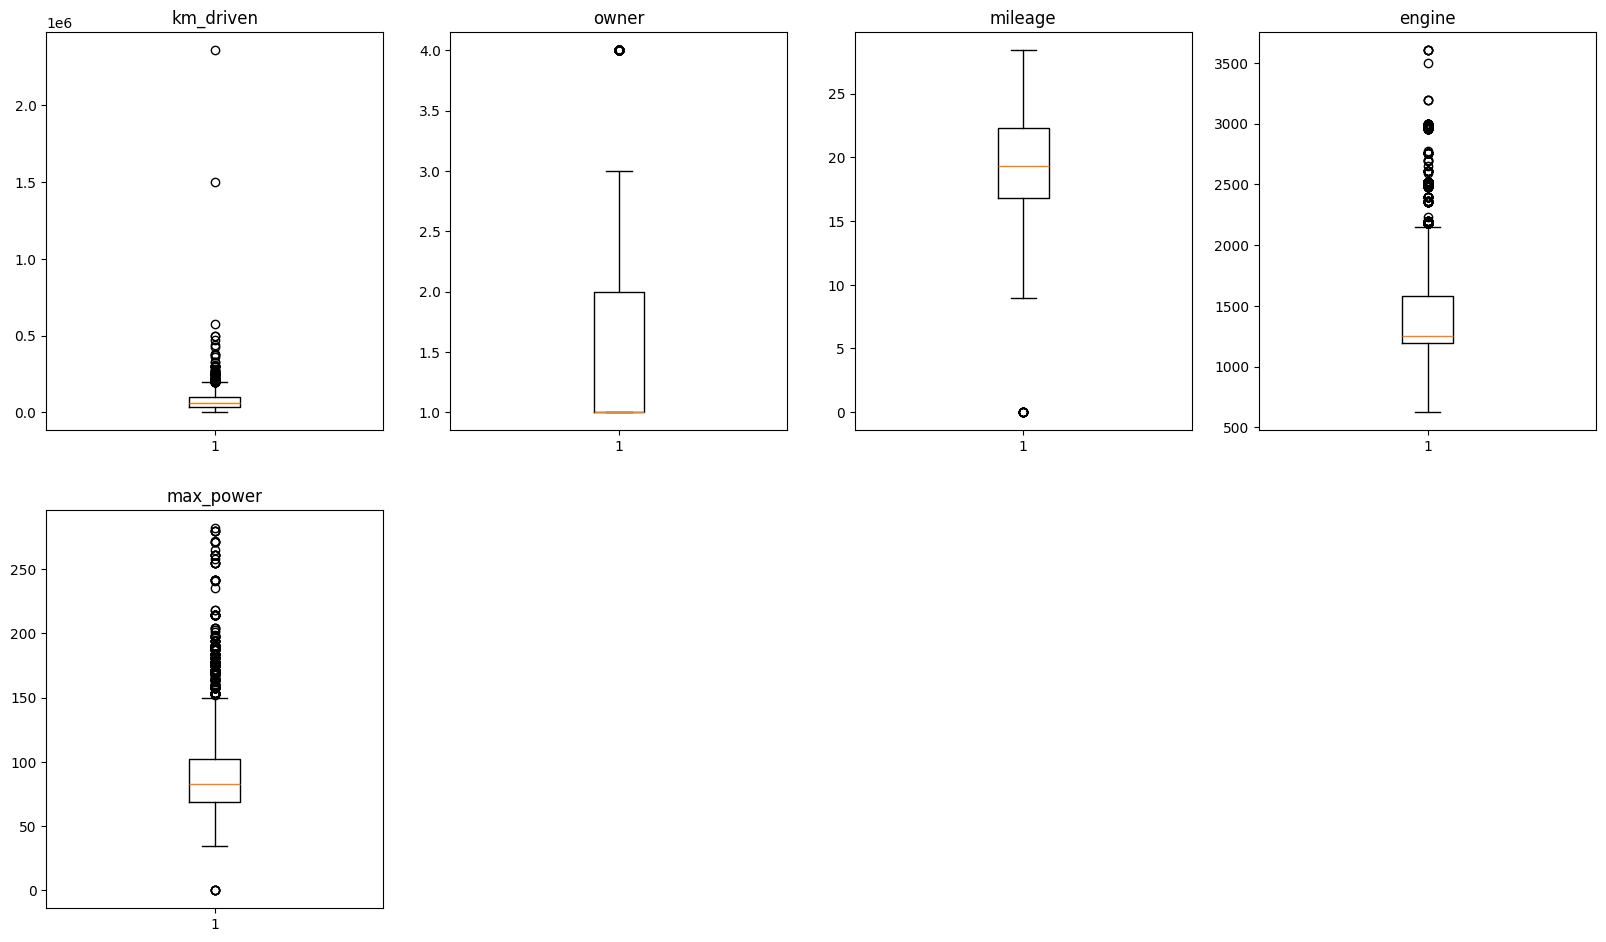

In [48]:
# Create a dictionary of columns.
col_dict = {'km_driven':1,'owner':2,'mileage':3,'engine':4,'max_power':5}

# Detect outliers in each variable using box plots.
plt.figure(figsize=(20,30))

for variable,i in col_dict.items():
                     plt.subplot(5,4,i)
                     plt.boxplot(X_train[variable])
                     plt.title(variable)

plt.show()

In [49]:
def outlier_count(col, data = X_train):
    
    # calculate your 25% quatile and 75% quatile
    q75, q25 = np.percentile(data[col], [75, 25])
    
    # calculate your inter quatile
    iqr = q75 - q25
    
    # min_val and max_val
    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    
    # count number of outliers, which are the data that are less than min_val or more than max_val calculated above
    outlier_count = len(np.where((data[col] > max_val) | (data[col] < min_val))[0])
    
    # calculate the percentage of the outliers
    outlier_percent = round(outlier_count/len(data[col])*100, 2)
    
    if(outlier_count > 0):
        print("\n"+15*'-' + col + 15*'-'+"\n")
        print('Number of outliers: {}'.format(outlier_count))
        print('Percent of data that is outlier: {}%'.format(outlier_percent))

In [50]:
numeric_columns = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
for col in numeric_columns:
    outlier_count(col)


---------------km_driven---------------

Number of outliers: 102
Percent of data that is outlier: 1.82%

---------------owner---------------

Number of outliers: 110
Percent of data that is outlier: 1.96%

---------------mileage---------------

Number of outliers: 14
Percent of data that is outlier: 0.25%

---------------engine---------------

Number of outliers: 836
Percent of data that is outlier: 14.88%

---------------max_power---------------

Number of outliers: 409
Percent of data that is outlier: 7.28%


In [51]:
X_train.head()

,km_driven,owner,mileage,engine,max_power
6853,120000,1,13.58,2499.0,72.40
1495,90000,2,15.96,2523.0,62.10
7904,92000,3,20.77,1248.0,88.76
1281,100000,2,18.80,1248.0,90.00
1421,120000,3,23.00,1396.0,90.00


In [52]:
X_test.head()

,km_driven,owner,mileage,engine,max_power
5948,35000,1,15.00,1368.0,90.00
6039,110000,1,19.67,1582.0,126.20
3069,60000,1,20.51,998.0,67.04
6531,80000,1,19.01,1461.0,108.45
322,29000,1,24.00,1186.0,73.97


Scaling data

In [53]:
from sklearn.preprocessing import StandardScaler
import joblib

# Select only high-value features for scaling
features_to_scale = ['km_driven', 'mileage', 'engine', 'max_power']

scaler = StandardScaler()

X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])

joblib.dump(scaler, 'scaler.pkl')
print("Scaler saved as scaler.pkl")

Scaler saved as scaler.pkl


In [54]:
X_train.head()

,km_driven,owner,mileage,engine,max_power
6853,0.830335,1,-1.472315,2.084278,-0.547545
1495,0.331836,2,-0.871732,2.132328,-0.838350
7904,0.365070,3,0.342052,-0.420314,-0.085646
1281,0.498003,2,-0.155069,-0.420314,-0.050636
1421,0.830335,3,0.904783,-0.124008,-0.050636


In [55]:
X_test.head()

,km_driven,owner,mileage,engine,max_power
5948,-0.582079,1,-1.113984,-0.180066,-0.050636
6039,0.664169,1,0.064471,0.248378,0.971416
3069,-0.166663,1,0.276442,-0.920833,-0.698877
6531,0.165670,1,-0.102077,0.006127,0.470272
322,-0.681778,1,1.157129,-0.544443,-0.503219


Check Null again

In [56]:
X_train[['km_driven', 'owner', 'mileage', 'engine', 'max_power']].isna().sum()

km_driven    0
owner        0
mileage      0
engine       0
max_power    0
dtype: int64

In [57]:
X_test[['km_driven', 'owner', 'mileage', 'engine', 'max_power']].isna().sum()

km_driven    0
owner        0
mileage      0
engine       0
max_power    0
dtype: int64

In [58]:
# Let's check shapes of all X_train, X_test, y_train, y_test
print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (5619, 5)
Shape of X_test:  (2409, 5)
Shape of y_train:  (5619,)
Shape of y_test:  (2409,)


#### 4. Implementation

Modify the LinearRegression() in file 03 - Regularization.ipynb by adding the following new functions and options:
- Add function $r^2$
- Adjust Weight Initialization
- Add Momentum to Gradient Descent
- Add Plot Feature Importance function

This is the LinearRegression() function available in file 03 - Regularization.ipynb with the added function.

In [59]:
from sklearn.model_selection import KFold

class LinearRegression(object):
    
    #in this class, we add cross validation as well for some spicy code....
    kfold = KFold(n_splits=3)

    # user to choose between zeros initialization or xavier // init='zeros' or init='xavier'
    # add variable momentum
    def __init__(self, regularization, lr=0.001, method='batch', num_epochs=500, batch_size=50, cv=kfold, init='zeros', momentum=0.0):
        self.lr         = lr
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.method     = method
        self.cv         = cv
        self.regularization = regularization
        self.init       = init
        self.momentum   = momentum
        self.prev_step  = 0

    def mse(self, ytrue, ypred):
        ytrue = np.array(ytrue)  # แปลงเป็น numpy array ถ้ายังไม่เป็น
        if ytrue.ndim == 0:      # กรณี scalar ให้เปลี่ยนเป็น array หนึ่งมิติ
            ytrue = np.array([ytrue])
        return ((ypred - ytrue) ** 2).sum() / ytrue.shape[0]
    
    ### Add function r^2
    def r2(self, ytrue, ypred):
        ss_total = ((ytrue - ytrue.mean()) ** 2).sum()
        ss_residual = ((ytrue - ypred) ** 2).sum()
        return 1 - (ss_residual / ss_total)
    
    def fit(self, X_train, y_train):
            
        #create a list of kfold scores
        self.kfold_scores = list()
        
        #reset val loss
        self.val_loss_old = np.inf

        #kfold.split in the sklearn.....
        #5 splits
        for fold, (train_idx, val_idx) in enumerate(self.cv.split(X_train)):
            
            '''
            X_cross_train = X_train[train_idx]
            y_cross_train = y_train[train_idx]
            X_cross_val   = X_train[val_idx]
            y_cross_val   = y_train[val_idx]
            '''

            X_cross_train = X_train.iloc[train_idx]
            y_cross_train = y_train.iloc[train_idx]
            X_cross_val   = X_train.iloc[val_idx]
            y_cross_val   = y_train.iloc[val_idx]

            
            ### Xavier Initialization or Zero
            if self.init == 'zeros':
                self.theta = np.zeros(X_cross_train.shape[1])
            elif self.init == 'xavier':
                m = X_cross_train.shape[1]  #number of samples
                lower, upper = -1.0 / np.sqrt(m), 1.0 / np.sqrt(m)  #calculate the range for the weights
                self.theta = np.random.uniform(lower, upper, X_cross_train.shape[1])    #randomly pick weights within range
            
            #define X_cross_train as only a subset of the data
            #how big is this subset?  => mini-batch size ==> 50
            
            #one epoch will exhaust the WHOLE training set
            with mlflow.start_run(run_name=f"Fold-{fold}", nested=True):
                
                params = {"method": self.method, "lr": self.lr, "reg": type(self).__name__}
                mlflow.log_params(params=params)
                
                for epoch in range(self.num_epochs):
                
                    #with replacement or no replacement
                    #with replacement means just randomize
                    #with no replacement means 0:50, 51:100, 101:150, ......300:323
                    #shuffle your index
                    perm = np.random.permutation(X_cross_train.shape[0])
                            
                    #X_cross_train = X_cross_train[perm]
                    #y_cross_train = y_cross_train[perm]

                    X_cross_train = X_cross_train.iloc[perm]
                    y_cross_train = y_cross_train.iloc[perm]
                    
                    if self.method == 'sto':
                        for batch_idx in range(X_cross_train.shape[0]):
                            X_method_train = X_cross_train.iloc[batch_idx].values.reshape(1, -1)
                            y_method_train = y_cross_train.iloc[batch_idx]
                            train_loss = self._train(X_method_train, y_method_train)
                    elif self.method == 'mini':
                        for batch_idx in range(0, X_cross_train.shape[0], self.batch_size):
                            #batch_idx = 0, 50, 100, 150
                            #X_method_train = X_cross_train[batch_idx:batch_idx+self.batch_size, :]
                            #y_method_train = y_cross_train[batch_idx:batch_idx+self.batch_size]
                            X_method_train = X_cross_train.iloc[batch_idx].values.reshape(1, -1)
                            y_method_train = y_cross_train.iloc[batch_idx]
                            train_loss = self._train(X_method_train, y_method_train)
                    else:
                        X_method_train = X_cross_train
                        y_method_train = y_cross_train
                        train_loss = self._train(X_method_train, y_method_train)

                    mlflow.log_metric(key="train_loss", value=train_loss, step=epoch)

                    yhat_val = self.predict(X_cross_val)
                    val_loss_new = self.mse(y_cross_val, yhat_val)
                    mlflow.log_metric(key="val_loss", value=val_loss_new, step=epoch)
                    
                    #early stopping
                    if np.allclose(val_loss_new, self.val_loss_old):
                        break
                    self.val_loss_old = val_loss_new
            
                self.kfold_scores.append(val_loss_new)
                print(f"Fold {fold}: {val_loss_new}")
            
    ### Add Momentum to Gradient Descent                
    def _train(self, X, y):
        yhat = self.predict(X)
        m    = X.shape[0]        
        grad = (1/m) * X.T @(yhat - y) + self.regularization.derivation(self.theta)

        #self.theta = self.theta - self.lr * grad

        step = self.lr * grad
        self.theta = self.theta - step + self.momentum * self.prev_step #updated Momentum
        self.prev_step = step   #save the value of the last step

        return self.mse(y, yhat)
    
    def predict(self, X):
        return X @ self.theta  #===>(m, n) @ (n, )
    
    def _coef(self):
        return self.theta[1:]  #remind that theta is (w0, w1, w2, w3, w4.....wn)
                               #w0 is the bias or the intercept
                               #w1....wn are the weights / coefficients / theta
    def _bias(self):
        return self.theta[0]
    
    ### Add Plot Feature Importance function
    def plot_feature_importance(self, feature_names=None):
        coef = self._coef()
        
        if feature_names is None:
            feature_names = [f"Feature {i}" for i in range(len(coef))]  # if no name feature

        plt.figure(figsize=(10, 5))
        plt.barh(feature_names, coef, color='blue')
        plt.xlabel("Coefficient Value")
        plt.ylabel("Feature")
        plt.title("Feature Importance")
        plt.show()

In [60]:
class LassoPenalty:
    
    def __init__(self, l):
        self.l = l # lambda value
        
    def __call__(self, theta): #__call__ allows us to call class as method
        return self.l * np.sum(np.abs(theta))
        
    def derivation(self, theta):
        return self.l * np.sign(theta)
    
class RidgePenalty:
    
    def __init__(self, l):
        self.l = l
        
    def __call__(self, theta): #__call__ allows us to call class as method
        return self.l * np.sum(np.square(theta))
        
    def derivation(self, theta):
        return self.l * 2 * theta
    
class ElasticPenalty:
    
    def __init__(self, l = 0.1, l_ratio = 0.5):
        self.l = l 
        self.l_ratio = l_ratio

    def __call__(self, theta):  #__call__ allows us to call class as method
        l1_contribution = self.l_ratio * self.l * np.sum(np.abs(theta))
        l2_contribution = (1 - self.l_ratio) * self.l * 0.5 * np.sum(np.square(theta))
        return (l1_contribution + l2_contribution)

    def derivation(self, theta):
        l1_derivation = self.l * self.l_ratio * np.sign(theta)
        l2_derivation = self.l * (1 - self.l_ratio) * theta
        return (l1_derivation + l2_derivation)
    
class Lasso(LinearRegression):
    
    def __init__(self, method, lr, l):
        self.regularization = LassoPenalty(l)
        super().__init__(self.regularization, lr, method)
        
class Ridge(LinearRegression):
    
    def __init__(self, method, lr, l):
        self.regularization = RidgePenalty(l)
        super().__init__(self.regularization, lr, method)
        
class ElasticNet(LinearRegression):
    
    def __init__(self, method, lr, l, l_ratio=0.5):
        self.regularization = ElasticPenalty(l, l_ratio)
        super().__init__(self.regularization, lr, method)

In [61]:
def generate_polynomial_features(X, degree=2):
    # Convert X to numpy array if it is a DataFrame
    if hasattr(X, "values"):
        X = X.values
        
    m, n = X.shape
    X_poly = [np.ones(m)]  # bias term

    for d in range(1, degree + 1):  # create features from x^1 to x^degree.
        for combo in combinations_with_replacement(range(n), d):
            new_feature = np.prod(X[:, combo], axis=1)
            X_poly.append(new_feature)

    return np.column_stack(X_poly)

### Task 2: Experiment

Use the same Jupyter Notebook from the A1: Predicting Car Price assignment, replacing the model part with the modified LinearRegression class.

In [62]:
import pickle
import itertools
import mlflow
import pandas as pd

methods       = ['batch', 'mini', 'sto']
lrs           = [0.01, 0.001, 0.0001]     
inits         = ['zeros', 'xavier']         
momentums     = [0.0, 0.9]                  # 0.0 = without momentum, 0.9 = momentum
regularizations = ['normal', 'lasso', 'ridge', 'polynomial'] 
degrees       = [1, 2]

experiment_results = []

# dummy regularization: normal (no have regularization)
class NoPenalty:
    def __call__(self, theta):
        return 0
    def derivation(self, theta):
        return 0

In [63]:
for method, lr, init, momentum, reg, degree in itertools.product(methods, lrs, inits, momentums, regularizations, degrees):
    # run MLflow by name run follow parameter
    run_name = f"{method}_lr{lr}_{init}_mom{momentum}_{reg}"
    if mlflow.active_run() is not None:
        mlflow.end_run()
    mlflow.start_run(run_name=run_name)
    
    X_train_mod = generate_polynomial_features(X_train, degree) if reg == 'polynomial' else X_train
    X_test_mod = generate_polynomial_features(X_test, degree) if reg == 'polynomial' else X_test

    if reg == 'normal':
        reg_penalty = NoPenalty()
        model = LinearRegression(regularization=reg_penalty, lr=lr, method=method, init=init, momentum=momentum)
    elif reg == 'lasso':
        model = Lasso(method=method, lr=lr, l=0.1)
        model.init = init
        model.momentum = momentum
    elif reg == 'ridge':
        model = Ridge(method=method, lr=lr, l=0.1)
        model.init = init
        model.momentum = momentum
    elif reg == 'polynomial':
        model = LinearRegression(regularization=NoPenalty(), lr=lr, method=method, init=init, momentum=momentum)
    
    mlflow.log_param("method", method)
    mlflow.log_param("lr", lr)
    mlflow.log_param("init", init)
    mlflow.log_param("momentum", momentum)
    mlflow.log_param("regularization", reg)
    mlflow.log_param("degree", degree)
    
    # train by tain data
    model.fit(X_train, y_train)
    
    # test
    y_pred = model.predict(X_test)
    
    # mse and r2
    mse_val = model.mse(y_test, y_pred)
    r2_val  = model.r2(y_test, y_pred)

    # save metric in MLflow
    mlflow.log_metric("test_mse", mse_val)
    mlflow.log_metric("test_r2", r2_val)

    # show Feature Importance only in models without regularization (normal, polynomial).
    # Lasso/Ridge reduces the coefficients, the interpretation of significance is unclear.
    #"km_driven", "owner", "mileage", "engine", "max_power"
    #if reg in ['normal', 'polynomial']:
    print(f"Method: {method}, LR: {lr}, Init: {init}, Momentum: {momentum}, Reg: {reg}")
    #feature_names = [f"X{i}" for i in range(1, X_train_mod.shape[1])]
    #feature_names = [f"X{i}" for i in range(len(model._coef()))]
    #model.plot_feature_importance(feature_names=feature_names)  
    # plt.show()

    mlflow.end_run()
    
    # save data to dataframe
    experiment_results.append({
        "method": method,
        "lr": lr,
        "init": init,
        "momentum": momentum,
        "regularization": reg,
        "degree": degree,
        "mse": mse_val,
        "r2": r2_val
    })

Fold 0: 30.59380788769303
Fold 1: 31.605537367553918
Fold 2: 32.13554144697486
Method: batch, LR: 0.01, Init: zeros, Momentum: 0.0, Reg: normal
Fold 0: 30.59380788769303
Fold 1: 31.605537367553918
Fold 2: 32.13554144697486
Method: batch, LR: 0.01, Init: zeros, Momentum: 0.0, Reg: normal
Fold 0: 30.901592548533692
Fold 1: 31.687769750060742
Fold 2: 32.1949271268733
Method: batch, LR: 0.01, Init: zeros, Momentum: 0.0, Reg: lasso
Fold 0: 30.901592548533696
Fold 1: 31.687769750060742
Fold 2: 32.1949271268733
Method: batch, LR: 0.01, Init: zeros, Momentum: 0.0, Reg: lasso
Fold 0: 32.14060434834687
Fold 1: 32.41971930194704
Fold 2: 32.91534997002628
Method: batch, LR: 0.01, Init: zeros, Momentum: 0.0, Reg: ridge
Fold 0: 32.14060434834687
Fold 1: 32.41971930194704
Fold 2: 32.91534997002628
Method: batch, LR: 0.01, Init: zeros, Momentum: 0.0, Reg: ridge
Fold 0: 30.59380788769303
Fold 1: 31.605537367553914
Fold 2: 32.13554144697486
Method: batch, LR: 0.01, Init: zeros, Momentum: 0.0, Reg: polyn

In [64]:
results_df = pd.DataFrame(experiment_results)
print(results_df)

    method      lr    init  momentum regularization  degree        mse  \
0    batch  0.0100   zeros       0.0         normal       1  31.934909   
1    batch  0.0100   zeros       0.0         normal       2  31.934909   
2    batch  0.0100   zeros       0.0          lasso       1  31.998868   
3    batch  0.0100   zeros       0.0          lasso       2  31.998868   
4    batch  0.0100   zeros       0.0          ridge       1  32.430674   
..     ...     ...     ...       ...            ...     ...        ...   
283    sto  0.0001  xavier       0.9          lasso       2  31.961961   
284    sto  0.0001  xavier       0.9          ridge       1  32.377546   
285    sto  0.0001  xavier       0.9          ridge       2  32.450929   
286    sto  0.0001  xavier       0.9     polynomial       1  31.924686   
287    sto  0.0001  xavier       0.9     polynomial       2  31.114038   

            r2  
0   -44.388724  
1   -44.388724  
2   -44.479628  
3   -44.479628  
4   -45.093349  
..       

In [65]:
best_models = results_df.sort_values(by="mse")
print(best_models.head(10))  # Top 10

    method     lr    init  momentum regularization  degree        mse  \
104   mini  0.010   zeros       0.9         normal       1  30.879479   
134   mini  0.001   zeros       0.0     polynomial       1  30.919584   
150   mini  0.001  xavier       0.0     polynomial       1  30.928942   
110   mini  0.010   zeros       0.9     polynomial       1  30.945511   
209    sto  0.010  xavier       0.0         normal       2  30.948124   
131   mini  0.001   zeros       0.0          lasso       2  30.960001   
121   mini  0.010  xavier       0.9         normal       2  30.963011   
243    sto  0.001  xavier       0.0          lasso       2  30.994040   
128   mini  0.001   zeros       0.0         normal       1  30.994121   
127   mini  0.010  xavier       0.9     polynomial       2  30.997508   

            r2  
104 -42.888654  
134 -42.945654  
150 -42.958955  
110 -42.982505  
209 -42.986217  
131 -43.003099  
121 -43.007377  
243 -43.051478  
128 -43.051593  
127 -43.056407  


I chose the model configuration with mini-batch training, a learning rate of 0.010, zeros initialization, a momentum of 0.9, normal regularization, and degree 1 because it produced the lowest test MSE. This means it had the best prediction accuracy compared to the other models I tested.

In [70]:
model_best = LinearRegression(regularization=NoPenalty(), lr=0.010, method='mini', init='zeros', momentum=0.9)

# train by tain data
model_best.fit(X_train, y_train)
    
# test
y_pred = model_best.predict(X_test)
    
# mse and r2
mse_val = model_best.mse(y_test, y_pred)
r2_val  = model_best.r2(y_test, y_pred)

#print("MSE: ", mse_val)
#print("r2: ", r2_val)

Fold 0: 30.16712382004558
Fold 1: 34.74276557264082
Fold 2: 32.32924236406058


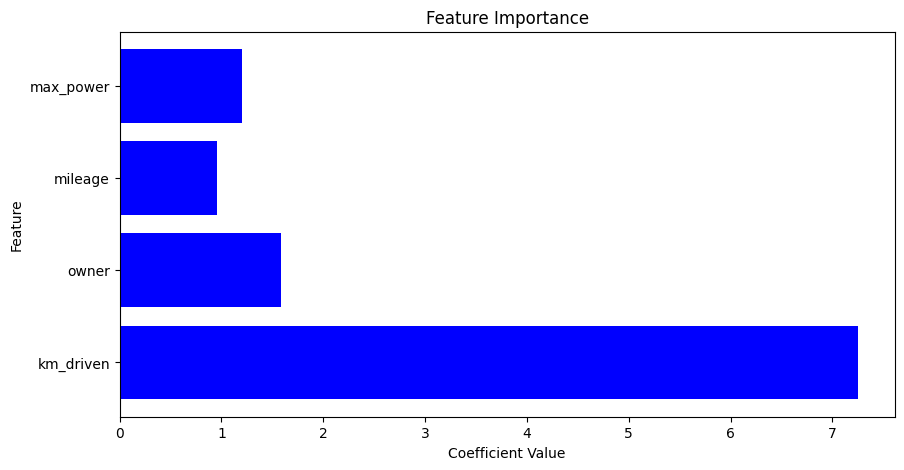

In [71]:
#'km_driven', 'owner', 'mileage', 'engine', 'max_power'
feature_names = ["km_driven", "owner", "mileage", "max_power"]
model_best.plot_feature_importance(feature_names=feature_names) 

In [72]:
# Save the model using pickle
with open('A2_car.pkl', 'wb') as file:
    pickle.dump(model_best, file)

Based on our experiments, the best model configuration is achieved using mini-batch gradient descent with a learning rate of 0.010, zeros initialization, a momentum of 0.9, normal regularization, and a degree of 1. This model produced the lowest MSE of 30.879 on the test set, meaning it predicted the target values with the highest accuracy compared to the other models. Although the R² value is -42.88 indicating that the model still struggles to explain the variance in the data—this configuration outperforms all others in our experiments.

Here is the comparative data from ML flow.

![Screenshot 2025-02-17 090803.png](<attachment:Screenshot 2025-02-17 090803.png>)
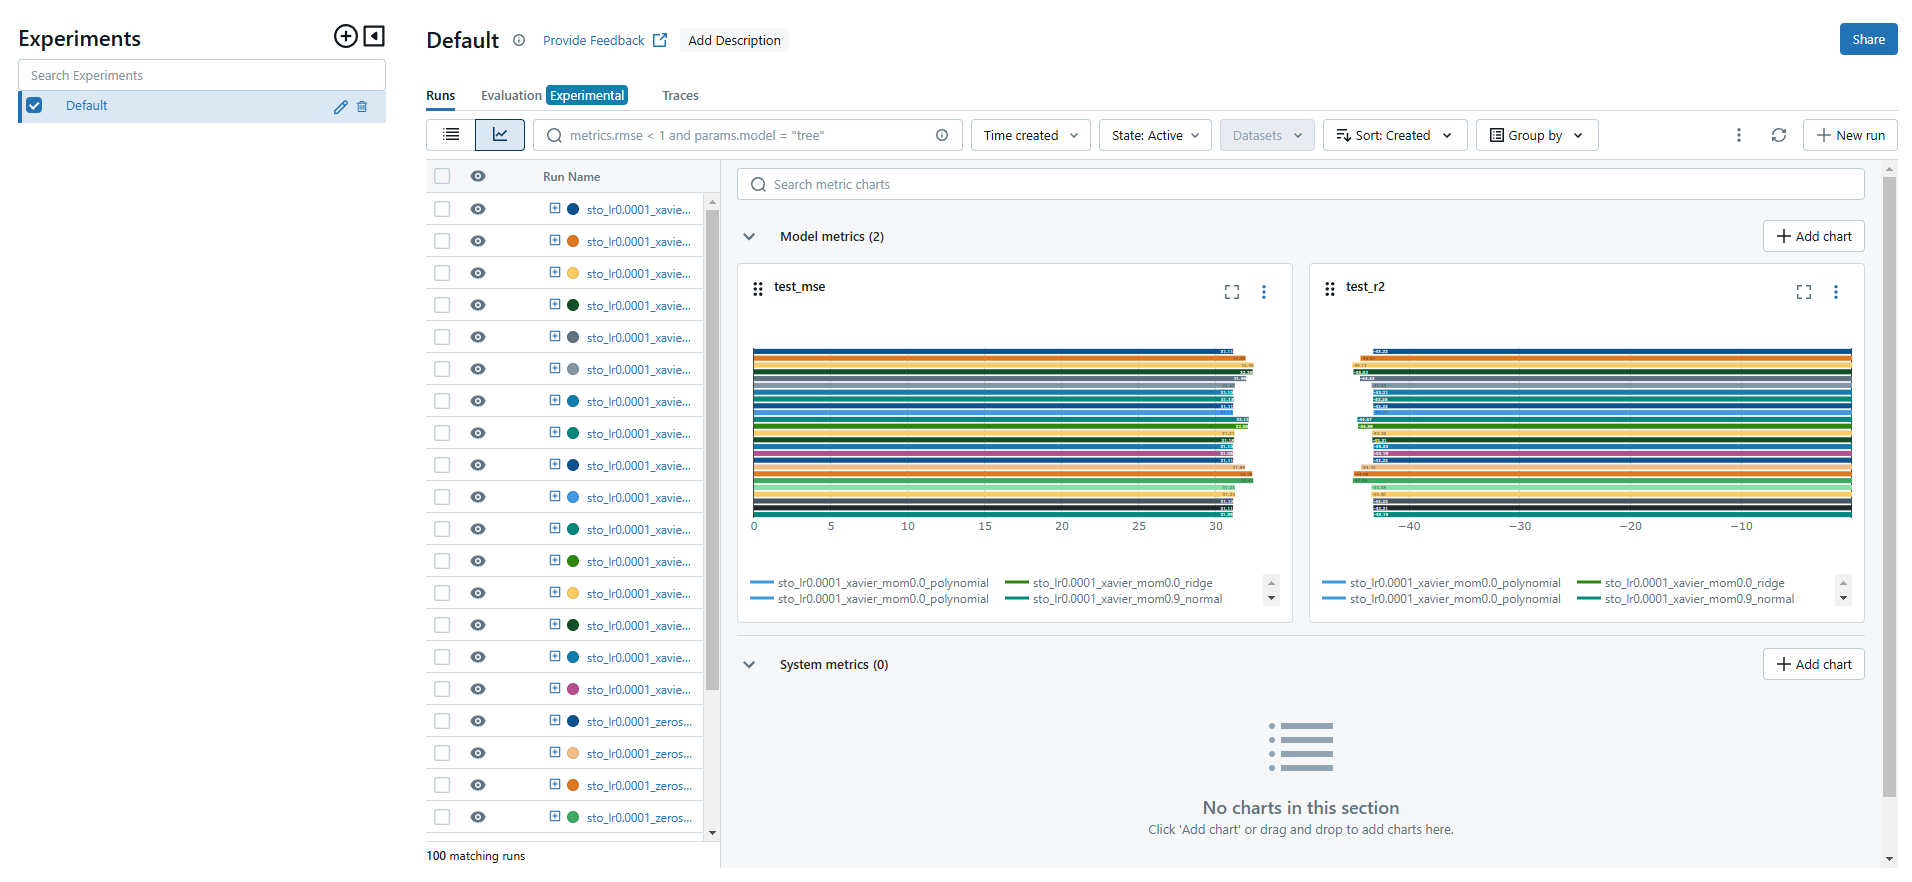

Here is a comparison graph of mse from some models displayed on ML flow.

![Screenshot 2025-02-17 091850.png](<attachment:Screenshot 2025-02-17 091850.png>)
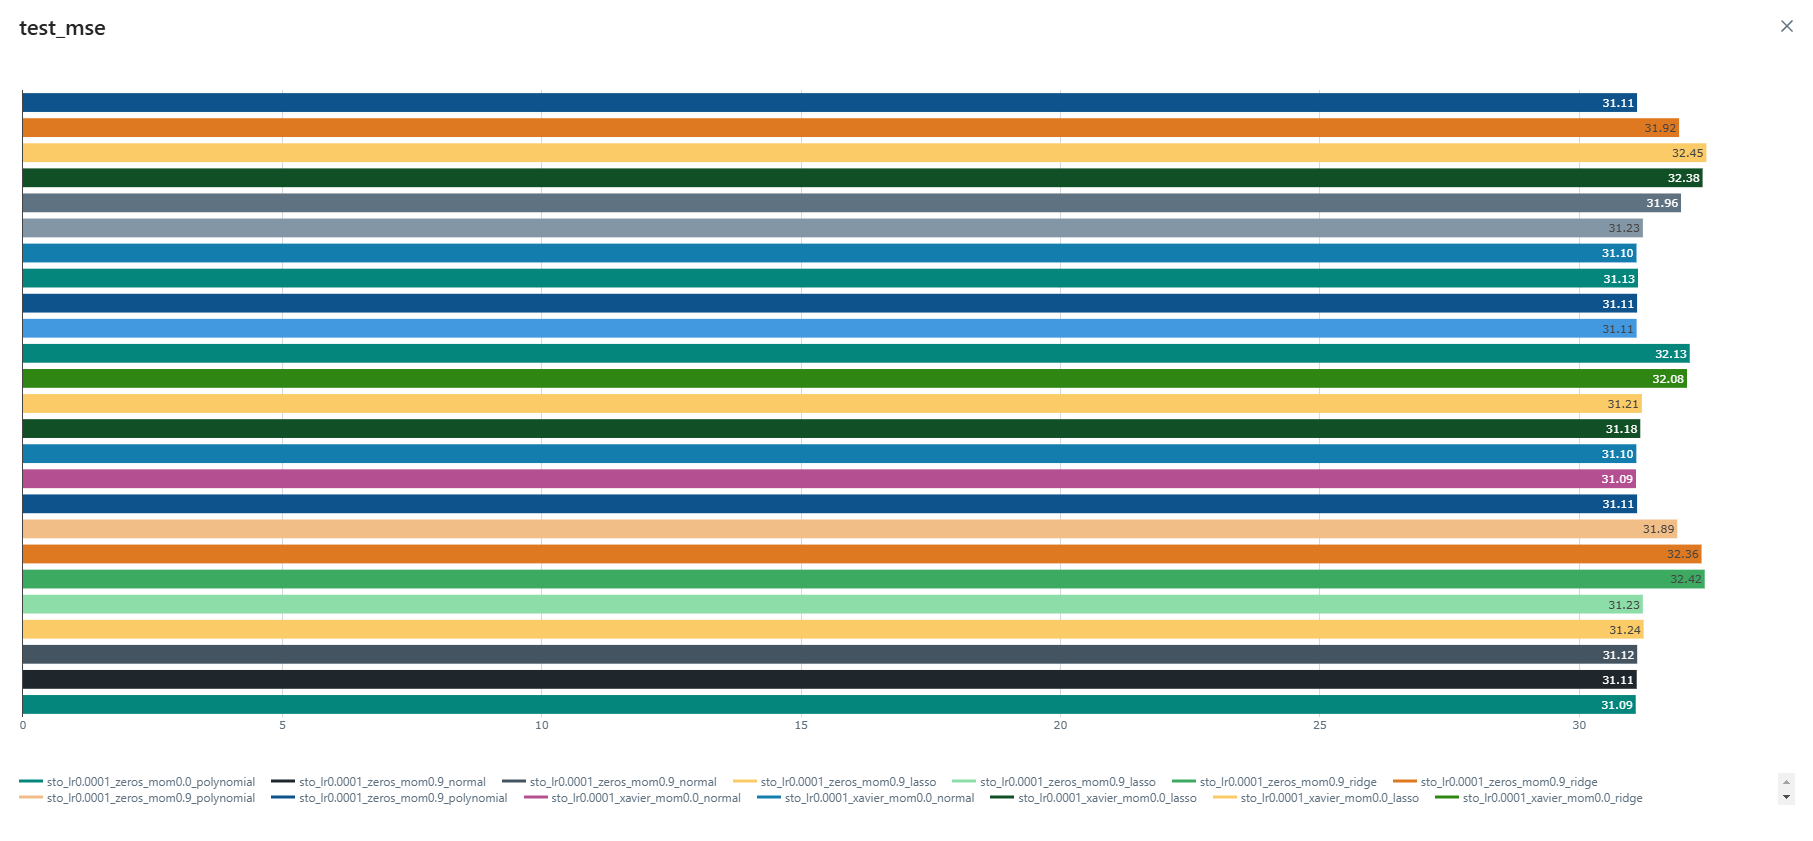

Here is the comparison result of the model with the lowest mse value.

![Screenshot 2025-02-17 093129.png](<attachment:Screenshot 2025-02-17 093129.png>)
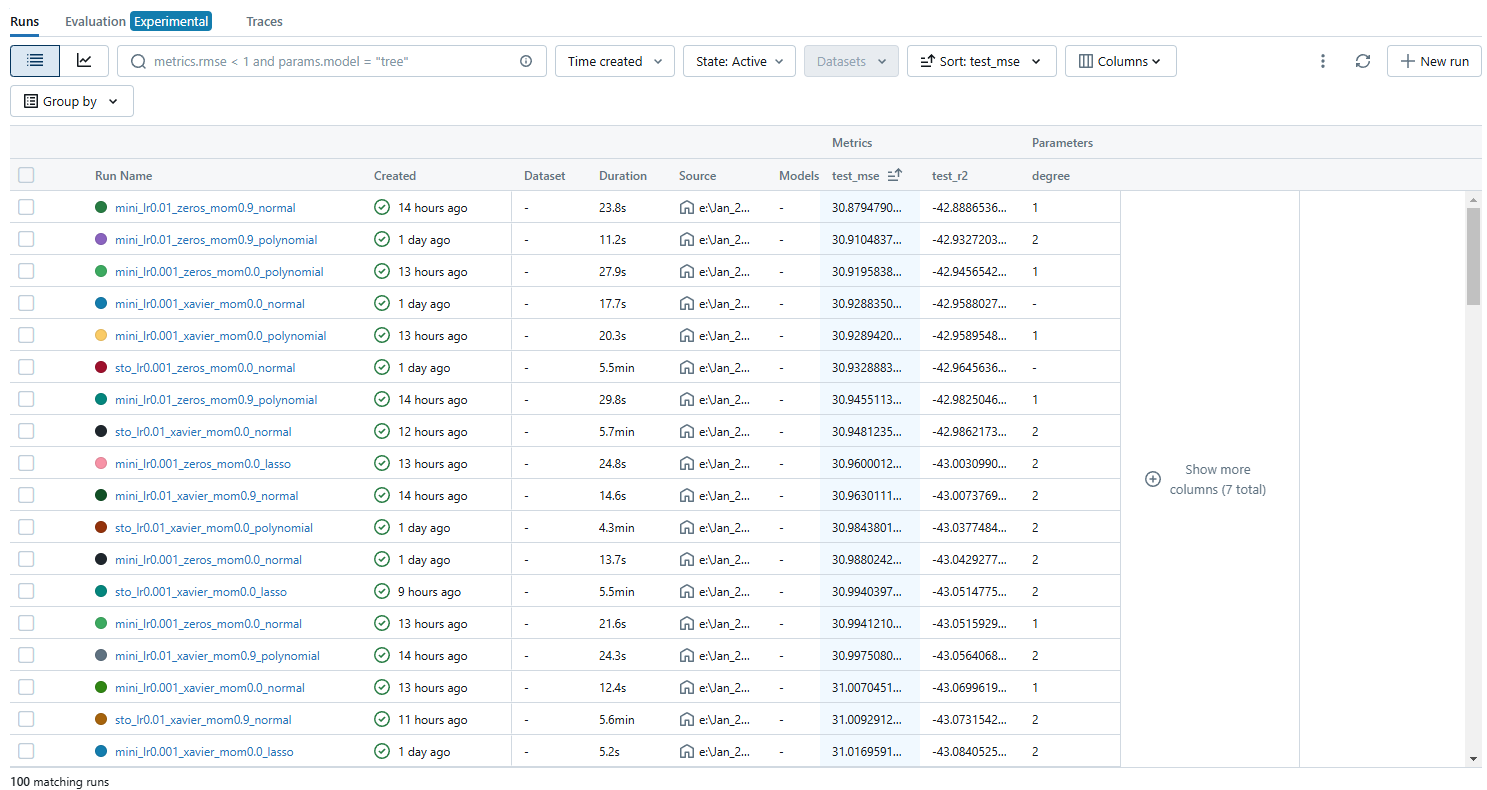

Comparison of Model Configurations

| Method | LR    | Init   | Momentum | Regularization | Degree | MSE     | R²      |
| ------ | ----- | ------ | -------- | -------------- | ------ | ------- | ------- |
| mini   | 0.010 | zeros  | 0.9      | normal         | 1      | 30.879  | -42.88  |
| mini   | 0.001 | zeros  | 0.0      | polynomial     | 1      | 30.919  | -42.94  |
| mini   | 0.001 | xavier | 0.0      | polynomial     | 1      | 30.928  | -42.95  |
| mini   | 0.010 | zeros  | 0.9      | polynomial     | 1      | 30.945  | -42.98  |
| sto    | 0.010 | xavier | 0.0      | normal         | 2      | 30.948  | -42.98  |
| mini   | 0.001 | zeros  | 0.0      | lasso          | 2      | 30.960  | -43.00  |
| mini   | 0.010 | xavier | 0.9      | normal         | 2      | 30.963  | -43.00  |
| sto    | 0.001 | xavier | 0.0      | lasso          | 2      | 30.994  | -43.05  |
| mini   | 0.001 | zeros  | 0.0      | normal         | 1      | 30.994  | -43.05  |
| mini   | 0.010 | xavier | 0.9      | polynomial     | 2      | 30.997  | -43.05  |

My experiment tested 289 different settings of a linear regression model to predict car prices. We changed training methods, learning rates, initialization types, momentum values, and regularization techniques. The best model used mini-batch gradient descent with a learning rate of 0.010, zeros initialization, momentum of 0.9, normal regularization, and degree 1. It had the lowest MSE of 30.879, meaning it made the most accurate predictions. However, the R² value of -42.88 shows that the model still does not fully explain the data. Feature importance analysis helped us see which factors mattered most, and MLflow tracking allowed us to compare different models. In the future, we can improve accuracy by choosing better features, adjusting parameters, and improving data processing.

### Task 3: Deployment

This is my web application on ml.brain server

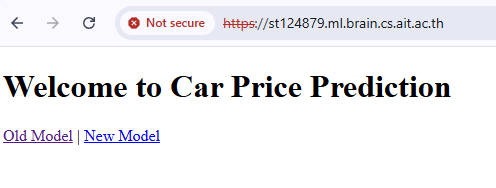

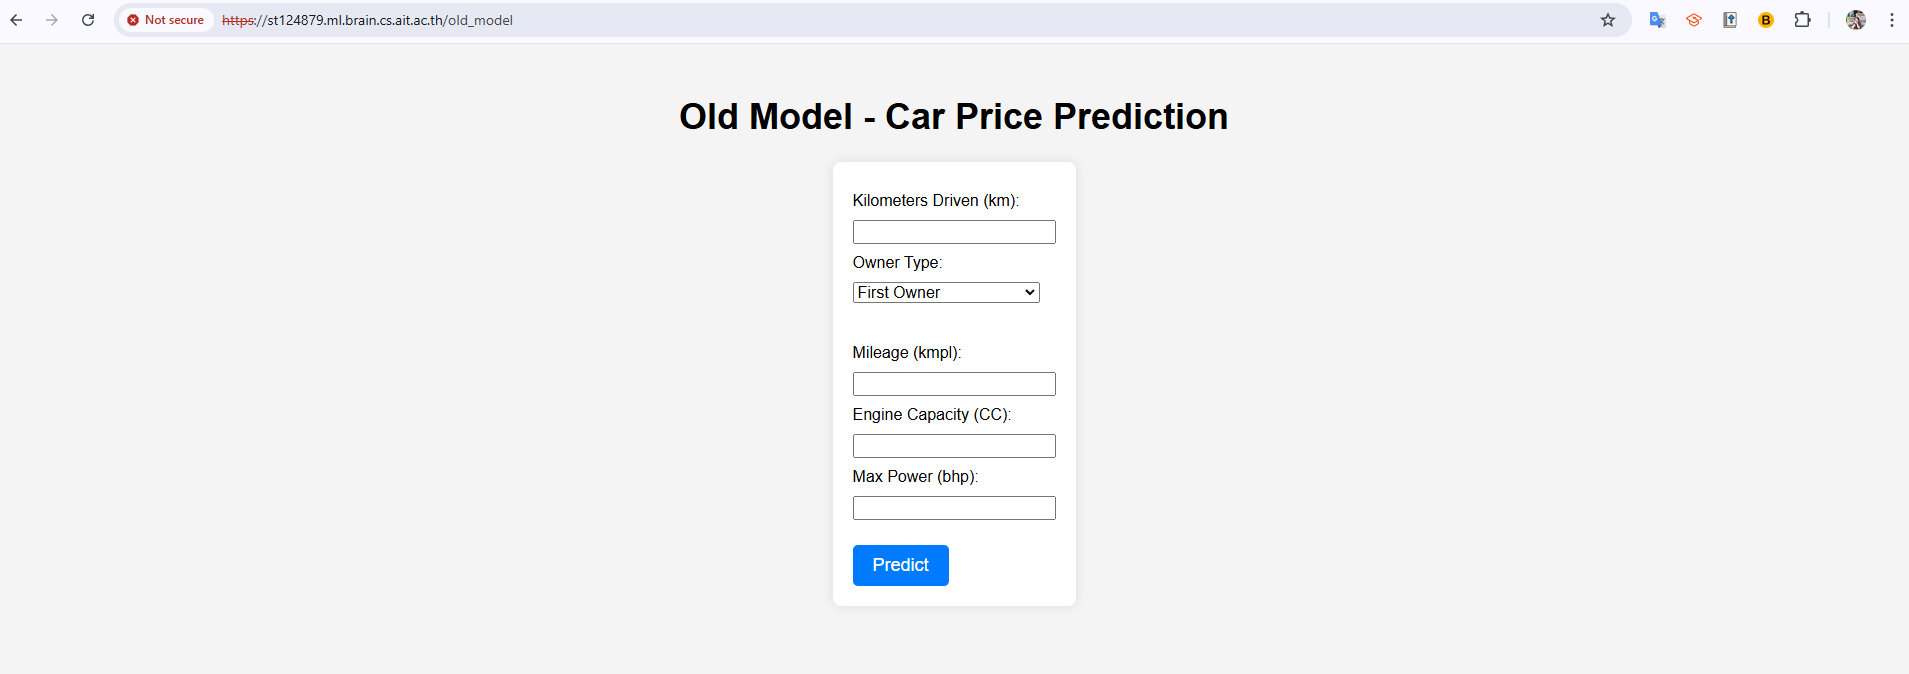

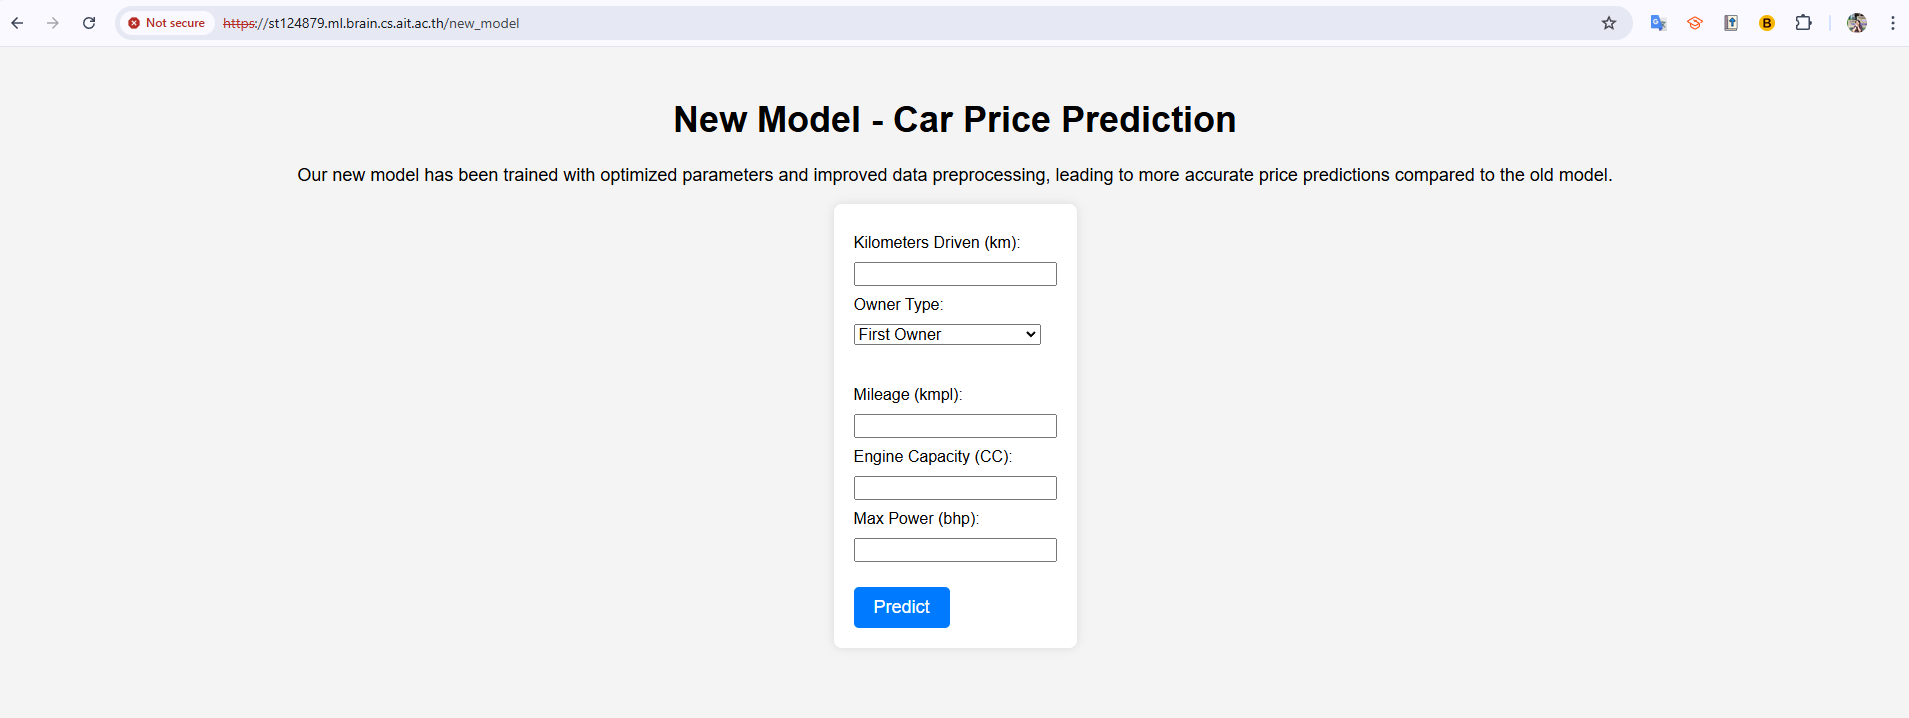